In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle


In [5]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c dog-breed-identification

100% 690M/691M [00:04<00:00, 149MB/s]
100% 691M/691M [00:04<00:00, 161MB/s]


In [9]:
from zipfile import ZipFile
data_path = '/content/dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')

The data set has been extracted.


In [10]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
df.shape

(10222, 2)

In [12]:
df['breed'].nunique()

120

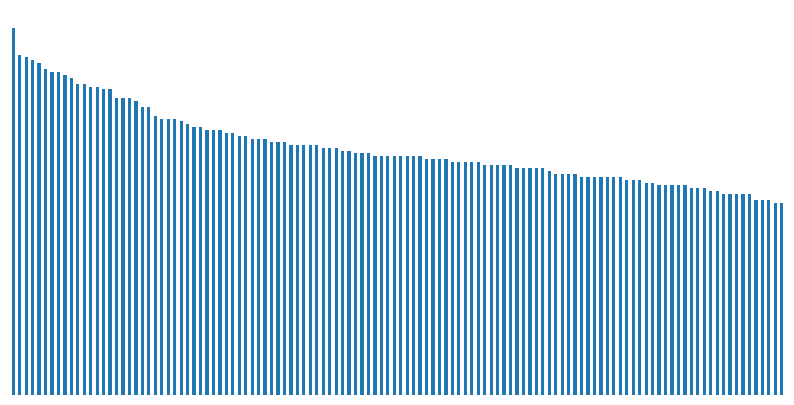

In [13]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [14]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


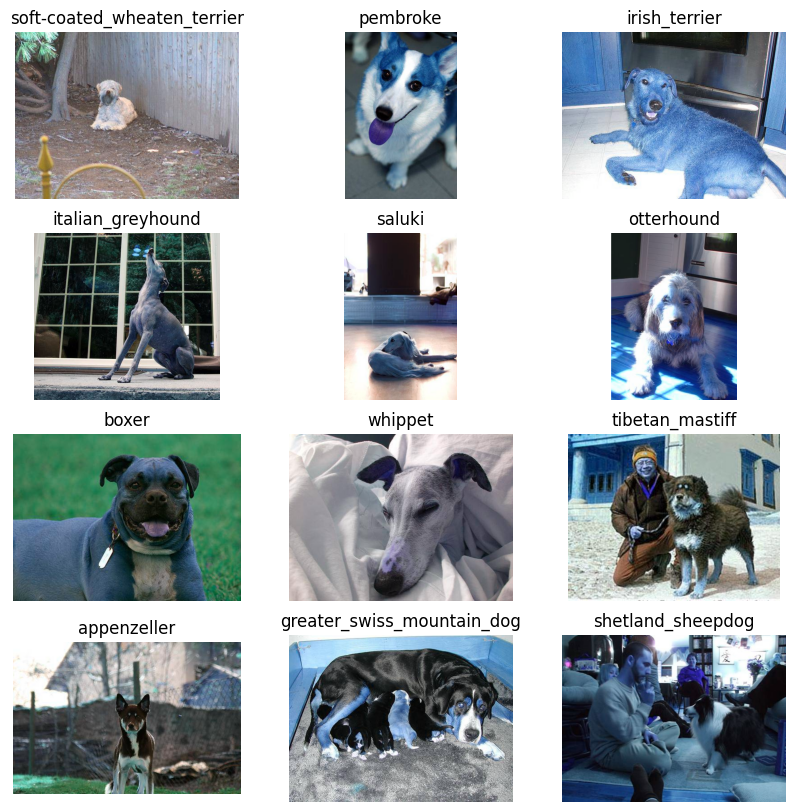

In [15]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

In [16]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [17]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)

X_train.shape, X_val.shape

((8688,), (1534,))

In [18]:
!pip uninstall -y albumentations

Found existing installation: albumentations 1.4.13
Uninstalling albumentations-1.4.13:
  Successfully uninstalled albumentations-1.4.13


In [19]:
!pip install albumentations

  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.0 MB/s eta 0:00:00
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.17
    Uninstalling pydantic-1.10.17:
      Successfully uninstalled pydantic-1.10.17


In [20]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

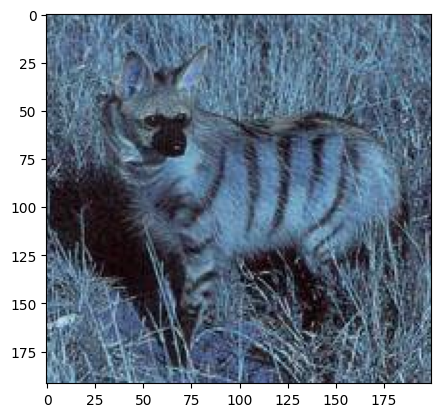

In [21]:
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()

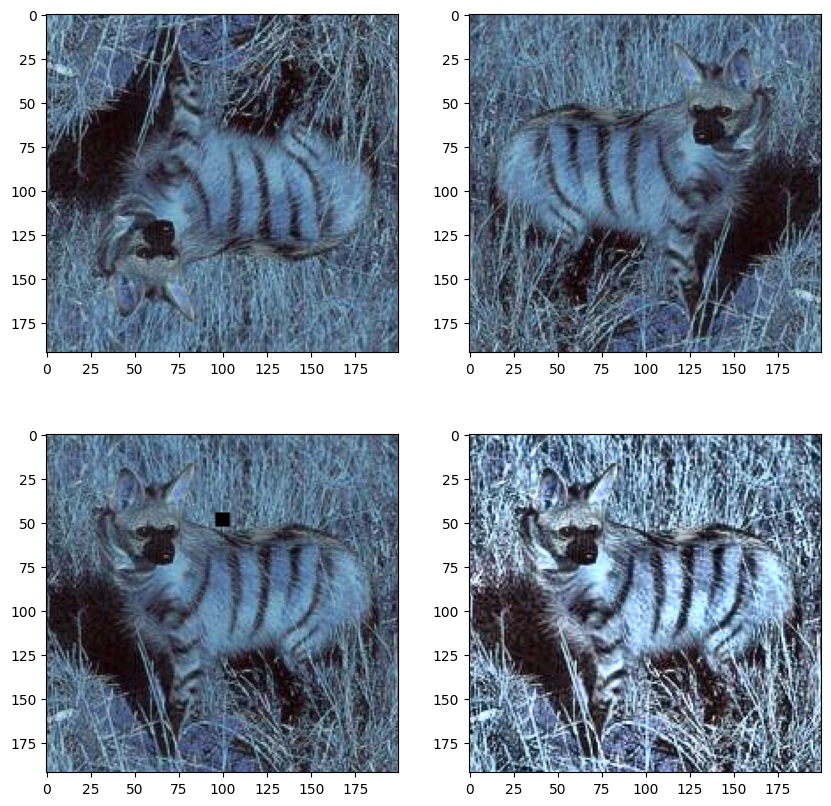

In [22]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()

In [23]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)

In [24]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [25]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
len(pre_trained_model.layers)

311

In [28]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

print('last layer output shape: ', last_output.shape)

last layer output shape:  (None, 6, 6, 768)


In [33]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC(name='auc')]
    )

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_auc = logs.get('val_auc')
        if val_auc is not None and val_auc > 0.99:
            print('\nValidation accuracy has reached 99%, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3,
                   mode='max',
                   monitor='val_auc',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [35]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 157s 547ms/step - auc: 0.5991 - loss: 4.9518 - val_auc: 0.9038 - val_loss: 3.3847 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 148s 543ms/step - auc: 0.8436 - loss: 3.7307 - val_auc: 0.9418 - val_loss: 2.8432 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 147s 540ms/step - auc: 0.9134 - loss: 3.1165 - val_auc: 0.9479 - val_loss: 2.6036 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 147s 539ms/step - auc: 0.9440 - loss: 2.6412 - val_auc: 0.9502 - val_loss: 2.4097 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 146s 538ms/step - auc: 0.9616 - loss: 2.2454 - val_auc: 0.9485 - val_loss: 2.3448 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 143s 525ms/step - auc: 0.9740 - loss: 1.9221 - val_auc: 0.9373 - val_loss: 2.3872 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 203s 528ms/step - auc: 0.9780 - loss: 1.7253 - val_auc: 0.9412 - val_loss: 2.2983 - 

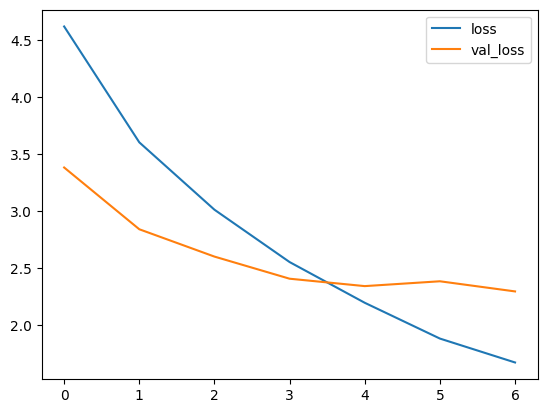

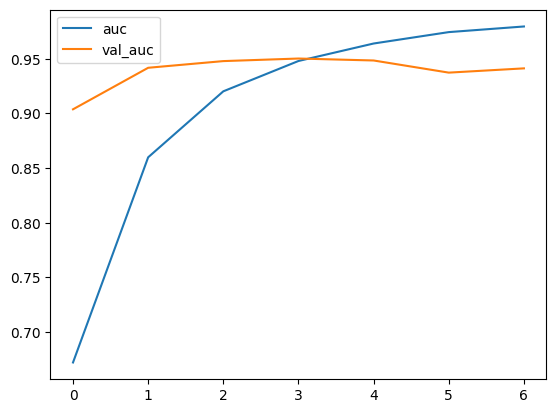

In [36]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()

In [37]:
from tensorflow.keras.saving import save_model

model.save('/content/dog_breed_classification.h5')

In [40]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

# 모델 로드
model = tf.keras.models.load_model('dog_breed_classification.h5')  # 모델의 경로로 변경

# 테스트 이미지 경로
test_folder_path = 'test/'  # test 폴더 경로

# 클래스 이름 목록 (예: 모델의 출력 클래스 수와 맞추어야 함)
class_names = class_name  # 실제 클래스 이름으로 대체

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))  # 모델의 입력 크기 (128, 128)로 변경
    img_array = np.array(img)
    img_array = img_array / 255.0  # 정규화
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    return img_array

# 예측 결과에서 가장 높은 확률의 인덱스를 찾고 클래스 이름으로 변환하는 함수
def get_predicted_class_name(predictions, class_names):
    predicted_index = np.argmax(predictions)
    return class_names[predicted_index]

# 테스트 폴더에 있는 모든 이미지 파일로 예측
for file_name in os.listdir(test_folder_path)[:5]:
    if file_name.endswith('.jpg'):
        file_path = os.path.join(test_folder_path, file_name)
        preprocessed_image = preprocess_image(file_path)
        predictions = model.predict(preprocessed_image)

        # 예측 결과에서 가장 높은 확률의 클래스 이름을 찾음
        predicted_class_name = get_predicted_class_name(predictions[0], class_names)

        print(f"Image: {file_name}, Predicted Class: {predicted_class_name}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: c9e71cac5943e36de66bb2d1ef43fb77.jpg, Predicted Class: border_collie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: 30d1871b796f7956bb0e4e5188d826e0.jpg, Predicted Class: chow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Image: 9a82b96f7fe2263d7174057e519e4c79.jpg, Predicted Class: australian_terrier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: 63cb25a12cedf0bb90269dd3a9caae99.jpg, Predicted Class: welsh_springer_spaniel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: c186e23242bfcc255b18670161dba094.jpg, Predicted Class: bernese_mountain_dog


In [46]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Load model
model = tf.keras.models.load_model('dog_breed_classification.h5')  # Change to your model path

# List of class names (should match the number of output classes in your model)
class_names = class_name  # Replace with your actual class names

# Image preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))  # Resize to model input size (128, 128)
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to get the top 3 predicted class names and their probabilities
def get_top_3_predictions(predictions, class_names):
    top_indices = np.argsort(predictions)[-3:][::-1]  # Get indices of top 3 predictions in descending order
    top_class_names = [class_names[i] for i in top_indices]  # Get the class names of the top predictions
    top_probabilities = [predictions[i] for i in top_indices]  # Get the probabilities of the top predictions

    # Create a list of tuples without using zip
    top_3 = []
    for i in range(len(top_class_names)):
        top_3.append((top_class_names[i], top_probabilities[i]))

    return top_3

# Path to the specific file (`download.webp`)
file_path = '/content/KakaoTalk_20240826_132812366.jpg'

# Make predictions
preprocessed_image = preprocess_image(file_path)
predictions = model.predict(preprocessed_image)[0]  # Get the prediction for the single image

# Get the top 3 predicted class names and their probabilities
top_3_predictions = get_top_3_predictions(predictions, class_names)

# Print the top 3 predictions
print("분류결과")
for i, (breed, prob) in enumerate(top_3_predictions):
    print(f"{breed} : {prob:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
분류결과
bedlington_terrier : 0.20
miniature_poodle : 0.14
toy_poodle : 0.09


In [ ]:
dataframe.columns.values[3] = "breed_encoding"
dataframe.columns.values[4] = "path"

In [39]:
class_name = ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
       'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael',
       'ibizan_hound', 'irish_setter', 'irish_terrier',
       'irish_water_spaniel', 'irish_wolfhound', 'italian_greyhound',
       'japanese_spaniel', 'keeshond', 'kelpie', 'kerry_blue_terrier',
       'komondor', 'kuvasz', 'labrador_retriever', 'lakeland_terrier',
       'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese_dog',
       'mexican_hairless', 'miniature_pinscher', 'miniature_poodle',
       'miniature_schnauzer', 'newfoundland', 'norfolk_terrier',
       'norwegian_elkhound', 'norwich_terrier', 'old_english_sheepdog',
       'otterhound', 'papillon', 'pekinese', 'pembroke', 'pomeranian',
       'pug', 'redbone', 'rhodesian_ridgeback', 'rottweiler',
       'saint_bernard', 'saluki', 'samoyed', 'schipperke',
       'scotch_terrier', 'scottish_deerhound', 'sealyham_terrier',
       'shetland_sheepdog', 'shih-tzu', 'siberian_husky', 'silky_terrier',
       'soft-coated_wheaten_terrier', 'staffordshire_bullterrier',
       'standard_poodle', 'standard_schnauzer', 'sussex_spaniel',
       'tibetan_mastiff', 'tibetan_terrier', 'toy_poodle', 'toy_terrier',
       'vizsla', 'walker_hound', 'weimaraner', 'welsh_springer_spaniel',
       'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier']

In [ ]:
class_name

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [44]:
print(zip)

<zipfile.ZipFile [closed]>
